In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import numpy as np
import json
import math
import time
from typing import List
from tap import Tap
from tqdm import tqdm
import joblib
import logging
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.transforms import Bbox
import seaborn as sns
from sklearn import metrics
from scipy import stats
import warnings

from SALib.sample import sobol as sobol_sample
from SALib.analyze import sobol as sobol_analyze

from apxinfer.core.config import OnlineArgs
from apxinfer.core.config import DIRHelper, LoadingHelper
from apxinfer.core.utils import is_same_float, XIPQType
from apxinfer.core.data import DBHelper
from apxinfer.core.pipeline import XIPPipeline
from apxinfer.examples.all_tasks import ALL_REG_TASKS, ALL_CLS_TASKS
from apxinfer.examples.run import get_ppl

# disable warning
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="No artists with labels found to put in legend.")
warnings.filterwarnings("ignore", message="Trying to unpickle estimator LinearRegression from version")

db_client = DBHelper.get_db_client()
database = "xip_0"
table = "trips_100"
cls_score = "acc"
reg_score = "r2"


task_name = "tickralfv2"
nops: int = 7
naggs: int = 1
agg_ids: List[int] = [6]
is_aggop: List[bool] = [False] * 6 + [True]

settings = {
    "task": "final/tickralfv2",
    "model": "lr",
    "seed": 0, 
    "pest": "biathlon",
    "pest_nsamples": 128,

    "scheduler_init": 5, 
    "scheduler_batch": 1 * naggs,
    "max_error": 0.04,
    "min_conf": 0.95,
}

args: OnlineArgs = OnlineArgs().from_dict(settings)
model = LoadingHelper.load_model(args)
model.get_feature_importances()

INFO:clickhouse_connect.driver.ctypes:Successfully imported ClickHouse Connect C data optimizations
INFO:clickhouse_connect.driver.ctypes:Successfully import ClickHouse Connect C/Numpy optimizations
INFO:clickhouse_connect.json_impl:Using python library for writing JSON byte strings


array([-2.28014563e-04, -3.74119074e-04,  1.07112943e-03, -3.46806525e-04,
        1.45602377e-04, -8.01071946e-04,  1.00055502e+00])

fnames: ['f_FSTORE_avg_bid_0_q0', 'f_FSTORE_avg_bid_0_q1', 'f_FSTORE_avg_bid_0_q2', 'f_FSTORE_avg_bid_0_q3', 'f_FSTORE_avg_bid_0_q4', 'f_FSTORE_avg_bid_0_q5', 'f_AGG_bid_avg_q6']
opnames: ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6']


<AxesSubplot:ylabel='Count'>

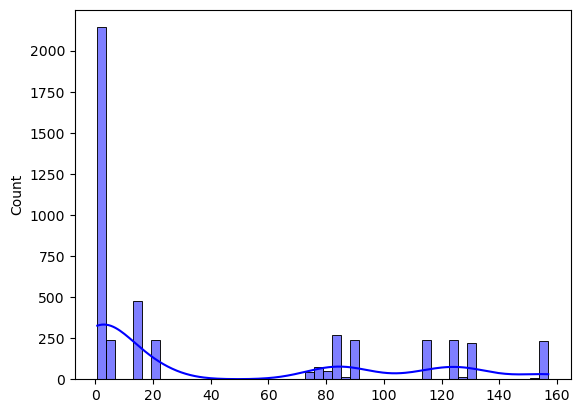

In [2]:
test_set = LoadingHelper.load_dataset(args, "test", args.nreqs, offset=args.nreqs_offset)
fnames = [col for col in test_set.columns if col.startswith("f_")]
fops = [fname.split('_')[-1] for fname in fnames]
opnames = sorted(list(set(fops)))
print(f'fnames: {fnames}')
print(f'opnames: {opnames}')

features = test_set[fnames].values
targets = test_set['label'].values
sns.histplot(targets, bins=50, kde=True, color='blue', label='label')

In [3]:
rid = 0
request = test_set.iloc[rid].to_dict()
x = features[rid]
y_true = targets[rid]
y_exact = model.predict(x.reshape(1, -1))[0]
x, y_true, y_exact

(array([1.077775  , 1.077268  , 1.07684028, 1.07674789, 1.07727599,
        1.0771786 , 1.07741606]),
 1.0777376,
 1.0772543298089736)

In [4]:
def generate_synthetic_data(x: float, operator: str,
                            dsize: int, seed: int,
                            ddist: str, **kwargs) -> np.ndarray:
    # generate {dsize} synthetic data that 
    # following {ddsit} distribution with {dist_args}
    # make sure that x == {operator}(data)
    rng = np.random.default_rng(0)
    if ddist == 'norm':
        std_value = kwargs.get('arg')
        data = rng.normal(x, std_value, dsize)
    elif ddist == 'uni':
        half_range = kwargs.get('arg')
        data = rng.uniform(x - half_range, x + half_range, dsize)
    elif ddist == 'zipf':
        alpha = kwargs.get('arg')
        data = rng.zipf(alpha, dsize).astype(float)
        data = np.minimum(data, dsize)
    elif ddist == 'reviewer':
        p, diff = kwargs.get('arg')
        x_num = int(dsize * p)
        data = np.array([x] * x_num + [x + diff] * (dsize - x_num))
    else:
        raise ValueError(f'Invalid distribution: {ddist}')

    if operator == 'mean':
        if not is_same_float(x, np.mean(data)):
            data = data + (x - np.mean(data))
        assert is_same_float(x, np.mean(data)), f'{x} != {np.mean(data)}'
    elif operator == 'median':
        if not is_same_float(x, np.median(data)):
            data = data + (x - np.median(data))
        assert is_same_float(x, np.median(data)), f'{x} != {np.median(data)}'
    elif operator == 'max':
        if not is_same_float(x, np.max(data)):
            data = data + (x - np.max(data))
        assert is_same_float(x, np.max(data)), f'{x} != {np.max(data)}'
    elif operator == 'min':
        if not is_same_float(x, np.min(data)):
            data = data + (x - np.min(data))
        assert is_same_float(x, np.min(data)), f'{x} != {np.min(data)}'
    else:
        raise ValueError(f'Invalid aggregation type: {operator}')
    
    # shuffule data
    rng = np.random.default_rng(seed)
    rng.shuffle(data)
    return data

In [5]:
default_dsize = 100_000 + 1
default_dsizes = [default_dsize] * nops
default_dists = ['reviewer'] * nops
default_dist_args = [(0.5 + 1e-5, 100) for i in range(nops)]
default_operators = [None] * (nops - 1) + [['median']]
default_dbseed = 0
default_rid = 0

In [6]:
def run(ppl: XIPPipeline, 
        dsizes: List[int] = default_dsizes,
        ddists: List[int] = default_dists,
        dist_args: list = default_dist_args,
        operators: List[str] = default_operators,
        dbseed: int = default_dbseed,
        rid: int = default_rid,
        keep_latency: bool = False,
        ) -> dict:
    request = test_set.iloc[rid].to_dict()
    x = features[rid]
    y_true = targets[rid]
    y_exact = ppl.model.predict(x.reshape(1, -1))[0]

    dataset = {qry.qname: generate_synthetic_data(x[qid], operators[qid][0],
                                                  dsizes[qid], dbseed,
                                                  ddists[qid],
                                                  arg=dist_args[qid]).reshape(-1, 1)
            for qid, qry in enumerate(ppl.fextractor.queries)
            if operators[qid] is not None}
    request['syn_data'] = dataset
    if keep_latency:
        request['keep_latency'] = True

    for qid, qry in enumerate(ppl.fextractor.queries):
        for i in range(len(qry.qops)):
            if operators[qid] is not None:
                qry.qops[i]['dops'] = operators[qid]
    
    xip_pred = ppl.serve(request, exact=False)
    latency = time.time() - ppl.start_time

    for qid, qry in enumerate(ppl.fextractor.queries):
        qry.set_enable_qcache()
        qry.set_enable_dcache()

    return {"xip_pred": xip_pred,
            "y_true": y_true,
            "y_exact": y_exact,
            "history": ppl.scheduler.history,
            "latency": latency,
            "request": request}

96 True 14.823443174362183 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0000000000000007]


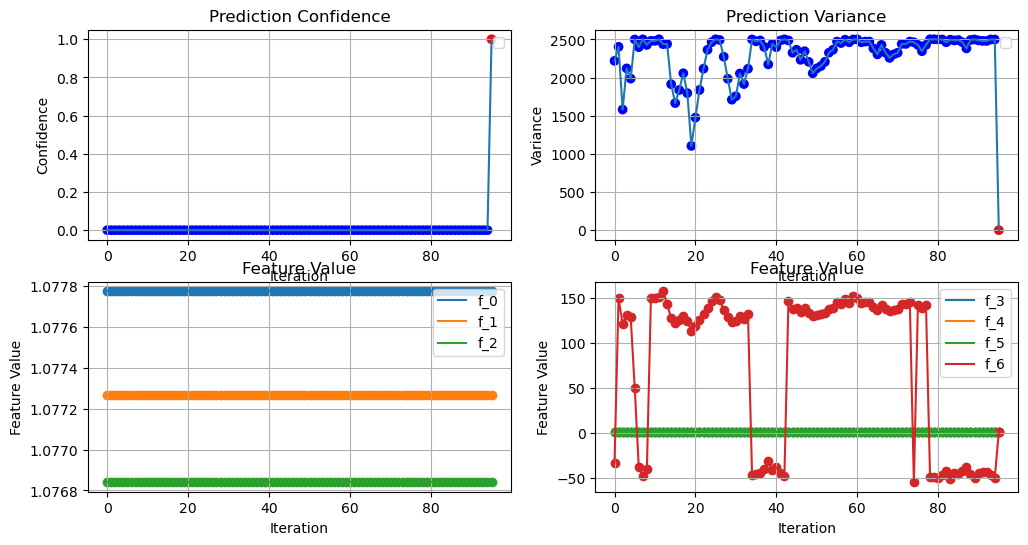

In [7]:

tmp_args: OnlineArgs = OnlineArgs().from_dict(settings)
tmp_args.bs_type = 'descrete'
tmp_args.bs_nresamples = 128
tmp_args.bs_feature_correction = True
tmp_args.bs_bias_correction = True
tmp_args.min_conf = 0.95
ppl: XIPPipeline = get_ppl(task_name, tmp_args, test_set, verbose=False)
res = run(ppl)
print(len(res['history']), res['y_exact'] == res['xip_pred']['pred_value'], res['latency'], [qcfg['qsample'] for qcfg in res['history'][-1]['qcfgs']])

pred_value_trace = np.array([hist['pred']['pred_value'] for hist in res['history']])
pred_conf_trace = np.array([hist['pred']['pred_conf'] for hist in res['history']])
pred_var_trace = np.array([hist['pred']['pred_var'] for hist in res['history']])

fval_trace = [[] for i in range(len(res['history']))]
fstd_trace = [[] for i in range(len(res['history']))]
for i, hist in enumerate(res['history']):
    fvals = hist['fvec']['fvals']
    fests = hist['fvec']['fests']
    fdists = hist['fvec']['fdists']
    for j in range(nops):
        fval_trace[i].append(fvals[j])
        if fdists[j] == 'unknown':
            fstd_trace[i].append(np.std(fests[j]))
        elif fdists[j] == 'fixed':
            fstd_trace[i].append(0)
        else:
            fstd_trace[i].append(fests[j])
fval_trace = np.array(fval_trace)
fstd_trace = np.array(fstd_trace)

# plot the traces
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()
x = np.arange(len(pred_value_trace))
axes[0].plot(pred_conf_trace)
axes[0].scatter(x, pred_conf_trace, c=['r' if is_same_float(pred_value_trace[i], y_exact) else 'b' for i in range(len(pred_value_trace))])
axes[0].set_title('Prediction Confidence')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Confidence')
axes[1].plot(pred_var_trace)
axes[1].scatter(x, pred_var_trace, c=['r' if is_same_float(pred_value_trace[i], y_exact) else 'b' for i in range(len(pred_value_trace))])
axes[1].set_title('Prediction Variance')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Variance')
for i in range(nops//2):
    axes[2].plot(fval_trace[:, i], label=f'f_{i}')
    axes[2].scatter(x, fval_trace[:, i])
axes[2].set_title('Feature Value')
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Feature Value')
for i in range(nops//2, nops):
    axes[3].plot(fval_trace[:, i], label=f'f_{i}')
    axes[3].scatter(x, fval_trace[:, i])
axes[3].set_title('Feature Value')
axes[3].set_xlabel('Iteration')
axes[3].set_ylabel('Feature Value')

for ax in axes:
    ax.legend()
    ax.grid()

plt.show()

p:   0%|          | 0/10 [00:00<?, ?it/s]/home/ckchang/anaconda3/envs/amd/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.3.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
p:  10%|█         | 1/10 [00:14<02:13, 14.83s/it]/home/ckchang/anaconda3/envs/amd/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.3.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
p:  20%|██        | 2/10 [00:29<01:59, 14.89s/it]/home/ckchang/a

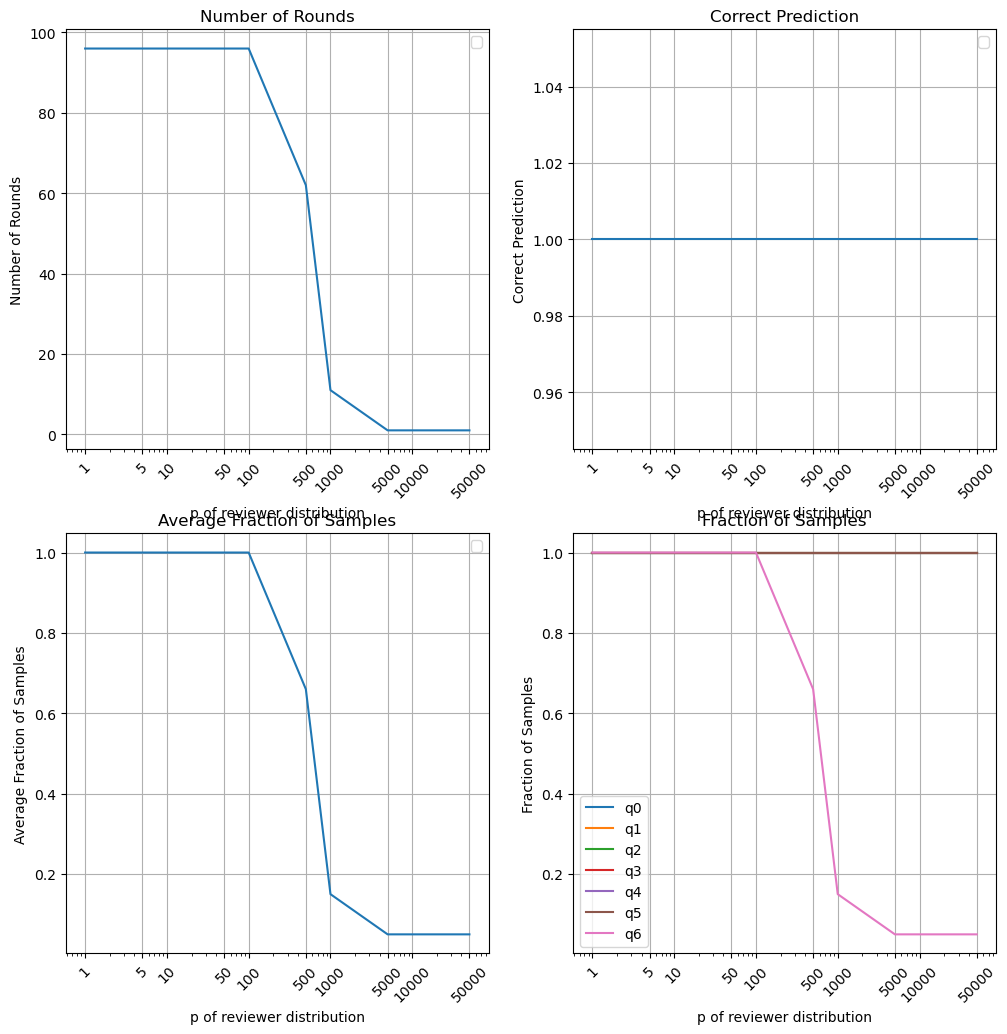

In [8]:
p_list = 0.5 + np.array([1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 0.5])
alpha_values = ((p_list - 0.5) * default_dsize).astype(int)
res_list = []
for p in tqdm(p_list, desc='p'):
    tmp_args: OnlineArgs = OnlineArgs().from_dict(settings)
    tmp_args.bs_type = 'descrete'
    tmp_args.bs_nresamples = 128
    tmp_args.bs_feature_correction = True
    tmp_args.bs_bias_correction = True
    tmp_args.min_conf = 0.95
    ppl: XIPPipeline = get_ppl(task_name, tmp_args, test_set, verbose=False)
    res = run(ppl, dist_args=[(p, 100)] * nops)
    res_list.append(res)

# plot the results
nround_list = np.array([len(res['history']) for res in res_list])
correct_list = np.array([is_same_float(res['xip_pred']['pred_value'], res['y_exact']) for res in res_list])
qsamples_list = np.array([[qcfg['qsample'] for qcfg in res['history'][-1]['qcfgs']] for res in res_list])
avg_samples_list = np.array([np.mean(qsamples[agg_ids]) for qsamples in qsamples_list])
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()
axes[0].plot(alpha_values, nround_list)
axes[0].set_title('Number of Rounds')
axes[0].set_ylabel('Number of Rounds')
axes[1].plot(alpha_values, correct_list)
axes[1].set_title('Correct Prediction')
axes[1].set_ylabel('Correct Prediction')
axes[2].plot(alpha_values, avg_samples_list)
axes[2].set_title('Average Fraction of Samples')
axes[2].set_ylabel('Average Fraction of Samples')
for qid in range(nops):
    axes[3].plot(alpha_values, qsamples_list[:, qid], label=f'q{qid}')
axes[3].set_title('Fraction of Samples')
axes[3].set_ylabel('Fraction of Samples')

for i, ax in enumerate(axes):
    ax.legend()
    ax.set_xlabel('p of reviewer distribution')
    ax.set_xscale('log')
    ax.set_xticks(alpha_values)
    ax.set_xticklabels([f'{alpha}' for alpha in alpha_values], rotation=45)
    ax.grid()

plt.show()

# Vary Feature Importance

In [9]:
model = LoadingHelper.load_model(args)
print(model.model.coef_)
default_coef = model.model.coef_[-1]
default_coef

[-2.28014563e-04 -3.74119074e-04  1.07112943e-03 -3.46806525e-04
  1.45602377e-04 -8.01071946e-04  1.00055502e+00]


/home/ckchang/anaconda3/envs/amd/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.3.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


1.000555023310117

## Scale Importance of AGG Features

scale:   0%|          | 0/7 [00:00<?, ?it/s]/home/ckchang/anaconda3/envs/amd/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.3.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ckchang/anaconda3/envs/amd/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.3.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ckchang/anaconda3/envs/amd/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning:

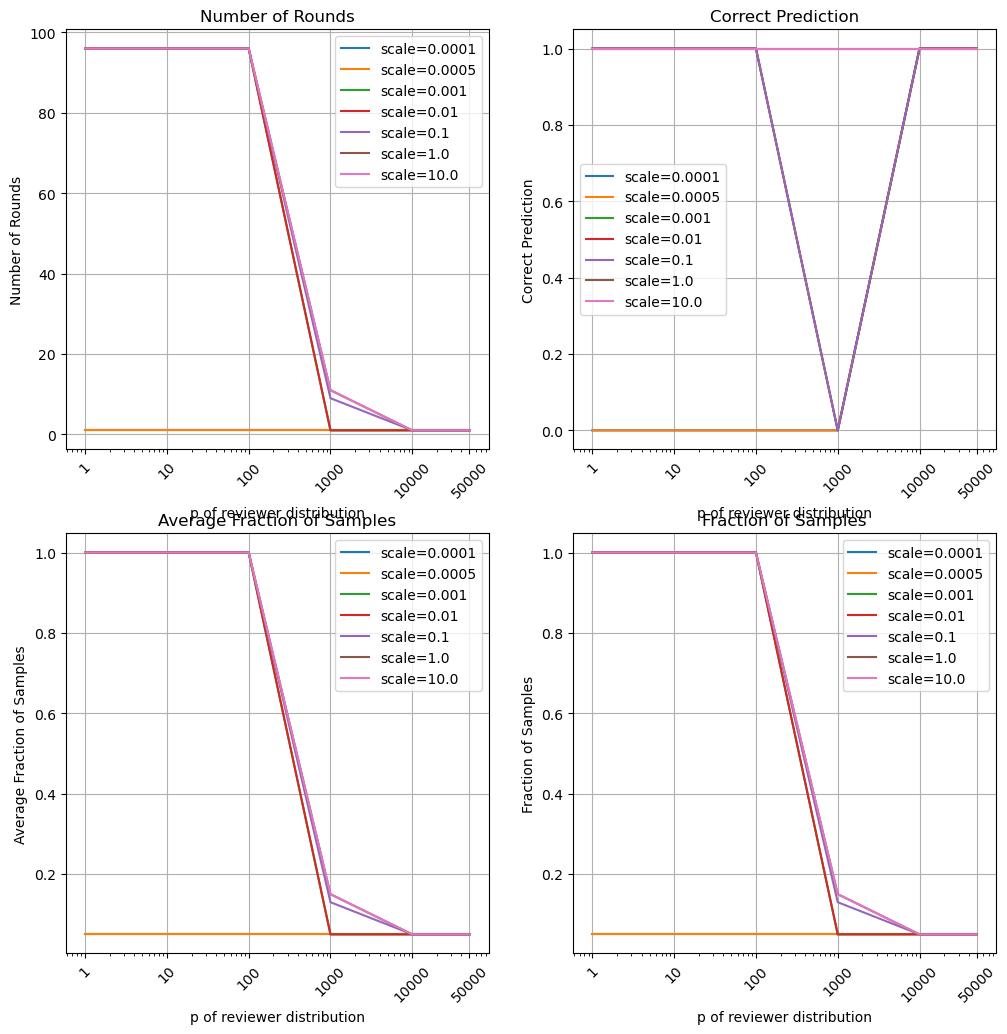

In [10]:
coef_scales = np.array([0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10])
p_list = 0.5 + np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5])
alpha_values = ((p_list - 0.5) * default_dsize).astype(int)

plotting_data = {
    "nround_list": [],
    "correct_list": [],
    "qsamples_list": [],
    "avg_samples_list": [],
}
for scale in tqdm(coef_scales, desc='scale'):
    res_list = []
    for p in tqdm(p_list, desc='p', leave=False):
        tmp_args: OnlineArgs = OnlineArgs().from_dict(settings)
        tmp_args.bs_type = 'descrete'
        tmp_args.bs_nresamples = 128
        tmp_args.bs_feature_correction = True
        tmp_args.bs_bias_correction = True
        tmp_args.min_conf = 0.95
        ppl: XIPPipeline = get_ppl(task_name, tmp_args, test_set, verbose=False)
        ppl.model.model.coef_[-1] *= scale
        res = run(ppl, dist_args=[(p, 100)] * nops)
        res_list.append(res)
    nround_list = np.array([len(res['history']) for res in res_list])
    correct_list = np.array([is_same_float(res['xip_pred']['pred_value'], res['y_exact']) for res in res_list])
    qsamples_list = np.array([[qcfg['qsample'] for qcfg in res['history'][-1]['qcfgs']] for res in res_list])
    avg_samples_list = np.array([np.mean(qsamples[agg_ids]) for qsamples in qsamples_list])

    plotting_data["nround_list"].append(nround_list)
    plotting_data["correct_list"].append(correct_list)
    plotting_data["qsamples_list"].append(qsamples_list)
    plotting_data["avg_samples_list"].append(avg_samples_list)

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()
for i, scale in enumerate(coef_scales):
    nround_list = plotting_data['nround_list'][i]
    correct_list = plotting_data['correct_list'][i]
    qsamples_list = plotting_data['qsamples_list'][i]
    avg_samples_list = plotting_data['avg_samples_list'][i]

    axes[0].plot(alpha_values, nround_list, label=f'scale={scale}')
    axes[1].plot(alpha_values, correct_list, label=f'scale={scale}')
    axes[2].plot(alpha_values, avg_samples_list, label=f'scale={scale}')
    axes[3].plot(alpha_values, qsamples_list[:, -1], label=f'scale={scale}')

axes[0].set_title('Number of Rounds')
axes[0].set_ylabel('Number of Rounds')
axes[1].set_title('Correct Prediction')
axes[1].set_ylabel('Correct Prediction')
axes[2].set_title('Average Fraction of Samples')
axes[2].set_ylabel('Average Fraction of Samples')
axes[3].set_title('Fraction of Samples')
axes[3].set_ylabel('Fraction of Samples')

for i, ax in enumerate(axes):
    ax.legend()
    ax.set_xlabel('p of reviewer distribution')
    ax.set_xscale('log')
    ax.set_xticks(alpha_values)
    ax.set_xticklabels([f'{alpha}' for alpha in alpha_values], rotation=45)
    ax.grid()

plt.show()

## Shuffle Importance Score

p:   0%|          | 0/10 [00:00<?, ?it/s]/home/ckchang/anaconda3/envs/amd/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.3.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
p:  10%|█         | 1/10 [00:14<02:13, 14.81s/it]/home/ckchang/anaconda3/envs/amd/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.3.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
p:  20%|██        | 2/10 [00:29<01:58, 14.81s/it]/home/ckchang/a

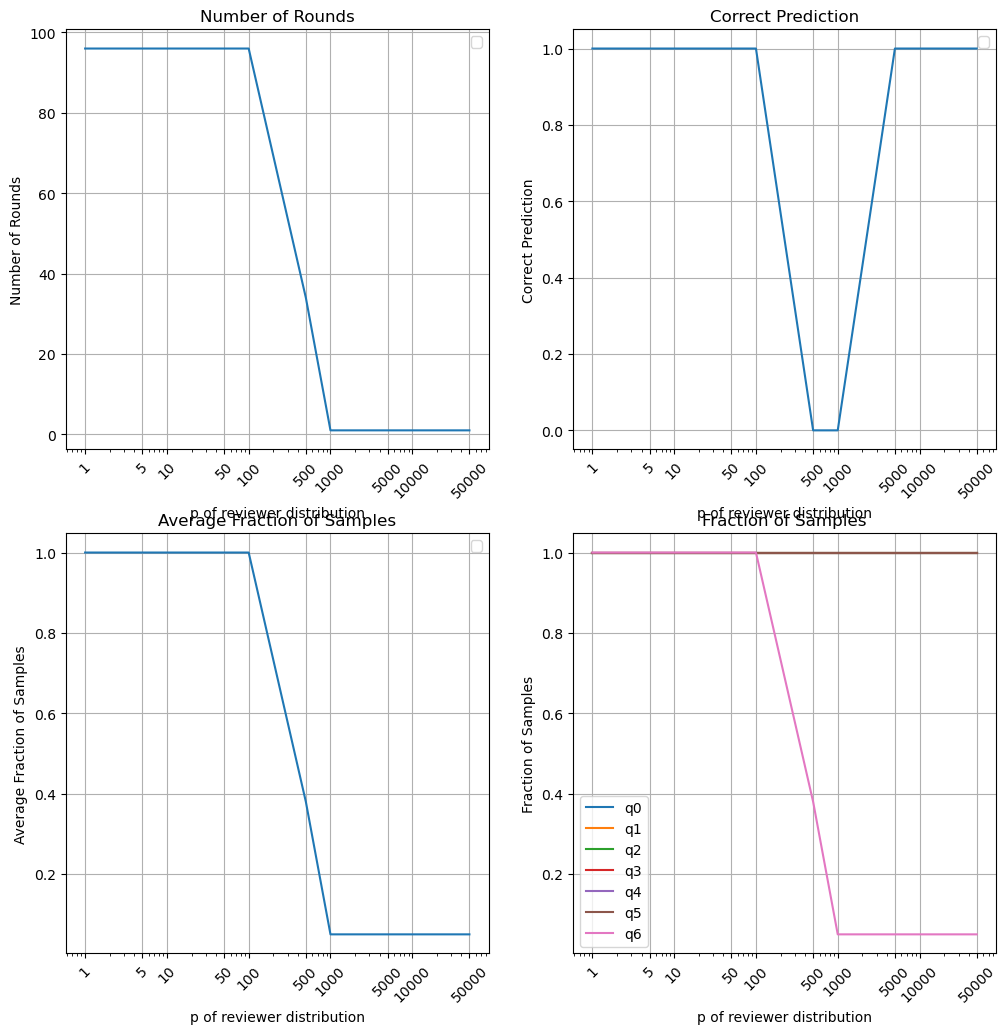

In [11]:
p_list = 0.5 + np.array([1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 0.5])
alpha_values = ((p_list - 0.5) * default_dsize).astype(int)
res_list = []
for p in tqdm(p_list, desc='p'):
    tmp_args: OnlineArgs = OnlineArgs().from_dict(settings)
    tmp_args.bs_type = 'descrete'
    tmp_args.bs_nresamples = 128
    tmp_args.bs_feature_correction = True
    tmp_args.bs_bias_correction = True
    tmp_args.min_conf = 0.95
    ppl: XIPPipeline = get_ppl(task_name, tmp_args, test_set, verbose=False)
    ppl.model.model.coef_[-1] = model.model.coef_[-2]
    ppl.model.model.coef_[-2] = model.model.coef_[-1]
    res = run(ppl, dist_args=[(p, 100)] * nops)
    res_list.append(res)

# plot the results
nround_list = np.array([len(res['history']) for res in res_list])
correct_list = np.array([is_same_float(res['xip_pred']['pred_value'], res['y_exact']) for res in res_list])
qsamples_list = np.array([[qcfg['qsample'] for qcfg in res['history'][-1]['qcfgs']] for res in res_list])
avg_samples_list = np.array([np.mean(qsamples[agg_ids]) for qsamples in qsamples_list])
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()
axes[0].plot(alpha_values, nround_list)
axes[0].set_title('Number of Rounds')
axes[0].set_ylabel('Number of Rounds')
axes[1].plot(alpha_values, correct_list)
axes[1].set_title('Correct Prediction')
axes[1].set_ylabel('Correct Prediction')
axes[2].plot(alpha_values, avg_samples_list)
axes[2].set_title('Average Fraction of Samples')
axes[2].set_ylabel('Average Fraction of Samples')
for qid in range(nops):
    axes[3].plot(alpha_values, qsamples_list[:, qid], label=f'q{qid}')
axes[3].set_title('Fraction of Samples')
axes[3].set_ylabel('Fraction of Samples')

for i, ax in enumerate(axes):
    ax.legend()
    ax.set_xlabel('p of reviewer distribution')
    ax.set_xscale('log')
    ax.set_xticks(alpha_values)
    ax.set_xticklabels([f'{alpha}' for alpha in alpha_values], rotation=45)
    ax.grid()

plt.show()

## Multiple Seeds

seed:   0%|          | 0/100 [00:00<?, ?it/s]/home/ckchang/anaconda3/envs/amd/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.3.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
seed:   1%|          | 1/100 [00:14<24:28, 14.83s/it]/home/ckchang/anaconda3/envs/amd/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.3.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
seed:   2%|▏         | 2/100 [00:29<24:21, 14.91s/it]/ho

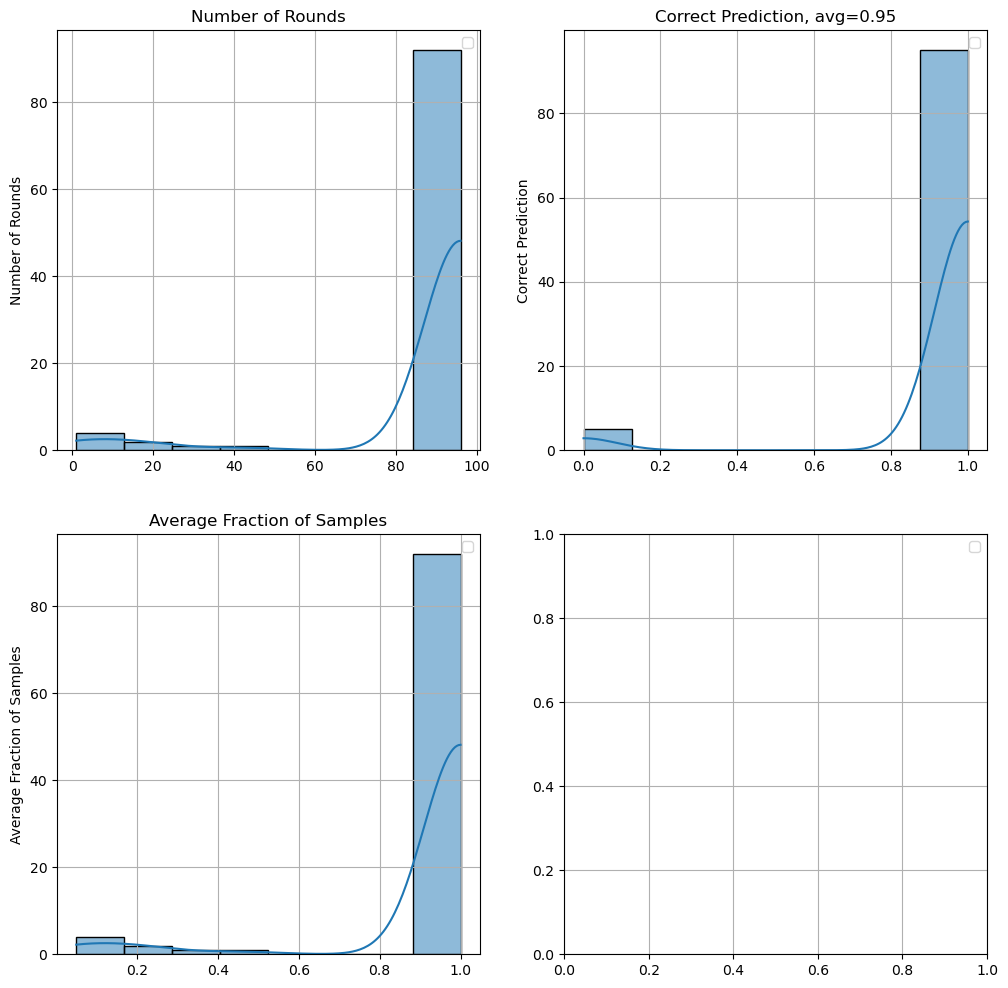

In [12]:
seed_list = list(range(100))
res_list = []
for seed in tqdm(seed_list, desc='seed'):
    tmp_args: OnlineArgs = OnlineArgs().from_dict(settings)
    tmp_args.bs_type = 'descrete'
    tmp_args.bs_nresamples = 128
    tmp_args.bs_feature_correction = True
    tmp_args.bs_bias_correction = True
    tmp_args.min_conf = 0.95
    ppl: XIPPipeline = get_ppl(task_name, tmp_args, test_set, verbose=False)
    res = run(ppl, dist_args=[(0.5 + 1e-5, 100)] * nops, dbseed=seed)
    res_list.append(res)

# plot the results
nround_list = np.array([len(res['history']) for res in res_list])
correct_list = np.array([is_same_float(res['xip_pred']['pred_value'], res['y_exact']) for res in res_list])
qsamples_list = np.array([[qcfg['qsample'] for qcfg in res['history'][-1]['qcfgs']] for res in res_list])
avg_samples_list = np.array([np.mean(qsamples[agg_ids]) for qsamples in qsamples_list])

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

sns.histplot(nround_list, ax=axes[0], kde=True)
axes[0].set_title('Number of Rounds')
axes[0].set_ylabel('Number of Rounds')
sns.histplot(correct_list, ax=axes[1], kde=True)
axes[1].set_title(f'Correct Prediction, avg={np.mean(correct_list):.2f}')
axes[1].set_ylabel('Correct Prediction')
sns.histplot(avg_samples_list, ax=axes[2], kde=True)
axes[2].set_title('Average Fraction of Samples')
axes[2].set_ylabel('Average Fraction of Samples')

for i, ax in enumerate(axes):
    ax.legend()
    # ax.set_xlabel('data seed')
    # ax.set_xscale('log')
    # ax.set_xticks(dbseed_list)
    # ax.set_xticklabels(dbseed_list, rotation=45)
    ax.grid()

plt.show()